In [1]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.1 MB/s eta 0:00:00


Enter the maximum number of faces expected in the video: 6
2/2 [==============================] - 0s 33ms/step
Number of unique faces detected: 6
Select faces to blur:
0: 1 face(s)


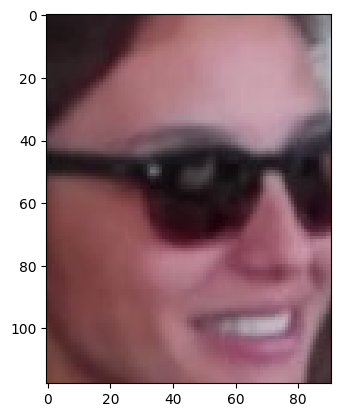

1: 1 face(s)


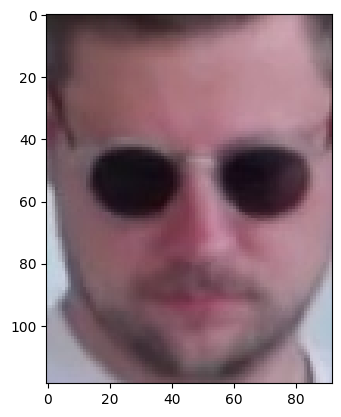

2: 1 face(s)


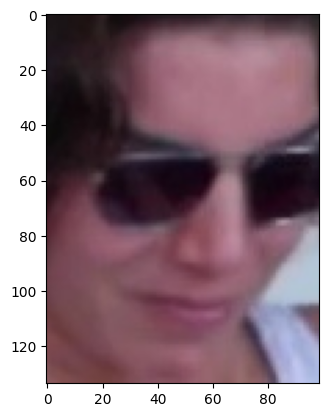

3: 1 face(s)


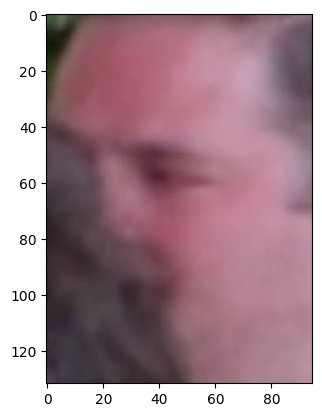

4: 1 face(s)


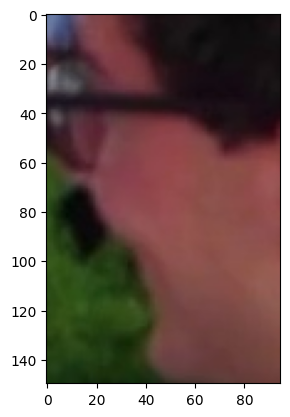

5: 1 face(s)


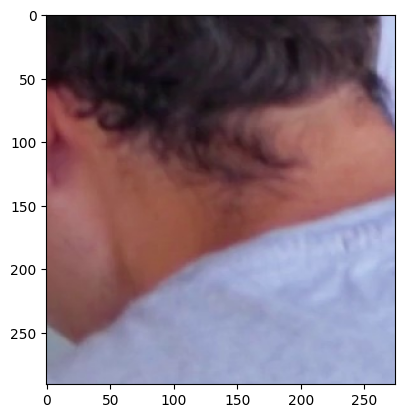

Enter the index of the person to blur (or 'done' to finish): 3
Enter the index of the person to blur (or 'done' to finish): 2
Enter the index of the person to blur (or 'done' to finish): done
Faces blurred successfully and video saved to 'output_video.mp4'.
The 'unique_faces' folder has been deleted.
Face blurring completed. You can view the modified video using a video player.


In [2]:
import cv2
import numpy as np
from mtcnn import MTCNN
import dlib
import os
import matplotlib.pyplot as plt

def blur_faces_video(video_path, output_path, max_faces=10, output_extension="mp4"):
    try:
        # Open the video file
        video_capture = cv2.VideoCapture(video_path)

        if not video_capture.isOpened():
            print(f"Error: Could not open video file '{video_path}'.")
            return False

        # Get the frames per second (fps) of the video
        fps = video_capture.get(cv2.CAP_PROP_FPS)

        # Get the width and height of the video frames
        frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

        # Initialize MTCNN detector
        mtcnn_detector = MTCNN()

        # Initialize directory to save unique face images
        save_dir = "unique_faces"
        os.makedirs(save_dir, exist_ok=True)

        # Initialize dictionary to keep track of unique faces
        unique_faces = {}

        # Initialize dictionary to keep track of face coordinates per person
        person_face_coordinates = {}

        # Define padding percentage (increase as needed)
        padding = 0.2

        # Counter to keep track of faces processed
        faces_processed = 0

        # Detect faces in the first frame and store their coordinates
        ret, frame = video_capture.read()
        if ret:
            # Convert the frame from BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Detect faces in the first frame using MTCNN
            detections = mtcnn_detector.detect_faces(rgb_frame)

            # Iterate through the detected faces
            for detection in detections:
                face_rect = detection['box']
                # Convert MTCNN box format (x, y, width, height) to dlib rectangle format
                face_rect = dlib.rectangle(left=int(face_rect[0]), top=int(face_rect[1]), right=int(face_rect[0] + face_rect[2]), bottom=int(face_rect[1] + face_rect[3]))

                # Save the face image
                face_img_path = os.path.join(save_dir, f"face_{len(unique_faces)}.jpg")
                cv2.imwrite(face_img_path, frame[face_rect.top():face_rect.bottom(), face_rect.left():face_rect.right()])

                # Add the face image path to the unique_faces dictionary
                unique_faces[len(unique_faces)] = face_rect
                # Add face coordinates for this person
                person_face_coordinates[len(unique_faces)-1] = [face_rect]

                # Increment the counter of faces processed
                faces_processed += 1

        # Print the number of unique faces detected
        print(f"Number of unique faces detected: {len(unique_faces)}")

        # Release video capture object
        video_capture.release()

        # Show the first face detected for each person
        print("Select faces to blur:")
        for idx, face_coords in person_face_coordinates.items():
            print(f"{idx}: {len(face_coords)} face(s)")
            first_face_img_path = os.path.join(save_dir, f"face_{idx}.jpg")
            first_face_img = cv2.imread(first_face_img_path)
            first_face_img = cv2.cvtColor(first_face_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            plt.imshow(first_face_img)
            plt.show()

        selected_faces = []
        while True:
            selected_idx = input("Enter the index of the person to blur (or 'done' to finish): ")
            if selected_idx.lower() == 'done':
                break

            try:
                selected_idx = int(selected_idx)
                if selected_idx in person_face_coordinates:
                    selected_faces.append(selected_idx)
                else:
                    print("Invalid index. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a number or 'done'.")

        # Re-open the video file
        video_capture = cv2.VideoCapture(video_path)

        if not video_capture.isOpened():
            print(f"Error: Could not open video file '{video_path}'.")
            return False

        while True:
            ret, frame = video_capture.read()

            if not ret:
                break

            # Convert the frame from BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Extend the face rectangle with padding before blurring
            for idx in selected_faces:
                for coord in person_face_coordinates[idx]:
                    padding_width = int(coord.width() * padding)
                    padding_height = int(coord.height() * padding)
                    top = max(0, coord.top() - padding_height)
                    bottom = min(frame_height, coord.bottom() + padding_height)
                    left = max(0, coord.left() - padding_width)
                    right = min(frame_width, coord.right() + padding_width)
                    face_region = frame[top:bottom, left:right]
                    if face_region is not None:
                        blurred_face = cv2.GaussianBlur(face_region, (99, 99), 0)
                        frame[top:bottom, left:right] = blurred_face

            # Write the modified frame to the output video
            out.write(frame)

        # Release video capture and writer objects
        video_capture.release()
        out.release()

        cv2.destroyAllWindows()
        print(f"Faces blurred successfully and video saved to '{output_path}'.")

        # Delete the unique_faces folder
        import shutil
        shutil.rmtree(save_dir)

        print(f"The '{save_dir}' folder has been deleted.")
        return True

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False

# Example usage
video_path = "input_video.mp4"  # Replace with your video file path
output_path = "output_video.mp4"  # You can change the extension here if needed
max_faces = int(input("Enter the maximum number of faces expected in the video: "))
if blur_faces_video(video_path, output_path, max_faces):
    print("Face blurring completed. You can view the modified video using a video player.")
